# Download Dataset to Content

In [1]:
!wget https://www.romanklinger.de/data-sets/GrimmingerKlingerWASSA2021.zip

--2023-02-11 11:13:37--  https://www.romanklinger.de/data-sets/GrimmingerKlingerWASSA2021.zip
Resolving www.romanklinger.de (www.romanklinger.de)... 51.75.78.158
Connecting to www.romanklinger.de (www.romanklinger.de)|51.75.78.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383645 (375K) [application/zip]
Saving to: ‘GrimmingerKlingerWASSA2021.zip’

GrimmingerKlingerWA 100%[===================>] 374.65K   798KB/s    in 0.5s    

2023-02-11 11:13:38 (798 KB/s) - ‘GrimmingerKlingerWASSA2021.zip’ saved [383645/383645]



# Unzip Dataset

In [2]:
!7za x /content/GrimmingerKlingerWASSA2021.zip


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 383645 bytes (375 KiB)

Extracting archive: /content/GrimmingerKlingerWASSA2021.zip
--
Path = /content/GrimmingerKlingerWASSA2021.zip
Type = zip
Physical Size = 383645

  0%    Everything is Ok

Files: 4
Size:       816853
Compressed: 383645


# Importing all Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import string
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

# Load the Dataset

In [4]:
dfraw=pd.read_csv('train.tsv',sep='\t')

In [5]:
dfraw.head()

,text,Trump,Biden,West,HOF
0,@SukiRavan @ProgressPotato @MarkZuckerb0rg @JS...,Neither,Favor,Neither,Non-Hateful
1,@Newsweek Are you freaking crazy????[NEWLINE]I...,Neither,Favor,Neither,Non-Hateful
2,Undecided voters (and MAGATs alike);[NEWLINE]I...,Against,Neutral mentions,Neither,Non-Hateful
3,@cheaterwins @Hungry_For_More @DAYSORSHAY So a...,Favor,Neutral mentions,Neither,Non-Hateful
4,@CNN Nancy Pelosi and the Dems wont do a deal ...,Neutral mentions,Neither,Neither,Non-Hateful


In [6]:
dfraw['HOF'].unique()

array(['Non-Hateful', 'Hateful'], dtype=object)

In [7]:
dfraw.shape

(2400, 5)

In [8]:
df=dfraw.copy()

#Data Cleaning

## Remove All Stopwords

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

## Remove HTTPS

In [11]:
import re
df['text'] = df['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [12]:
df

,text,Trump,Biden,West,HOF
0,@SukiRavan @ProgressPotato @MarkZuckerb0rg @JS...,Neither,Favor,Neither,Non-Hateful
1,@Newsweek Are you freaking crazy????[NEWLINE]I...,Neither,Favor,Neither,Non-Hateful
2,Undecided voters (and MAGATs alike);[NEWLINE]I...,Against,Neutral mentions,Neither,Non-Hateful
3,@cheaterwins @Hungry_For_More @DAYSORSHAY So a...,Favor,Neutral mentions,Neither,Non-Hateful
4,@CNN Nancy Pelosi and the Dems wont do a deal ...,Neutral mentions,Neither,Neither,Non-Hateful
...,...,...,...,...,...
2395,Just lost a ton of followers again. Looks like...,Favor,Neither,Neither,Non-Hateful
2396,@NovumQuid @OpenMothersMale @MikeSington I hav...,Neither,Mixed,Neither,Non-Hateful
2397,@TheLeoTerrell @SenatorLoeffler @realDonaldTru...,Favor,Neither,Neither,Non-Hateful
2398,It’s too bad that at a time when we’re unemplo...,Neither,Favor,Neither,Non-Hateful


## Other Cleaning

In [13]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# Remove Accented Chars
def remove_accented_chars_func(text):
    '''
    Removes all accented characters from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without accented characters
    '''
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
# Remove punctuation
def remove_punctuation_func(text):
    '''
    Removes all punctuation from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without punctuations
    '''
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)
# Remove Irrelevant Char
def remove_irr_char_func(text):
    '''
    Removes all irrelevant characters (numbers and punctuation) from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without irrelevant characters
    '''
    return re.sub(r'[^a-zA-Z]', ' ', text)
#Remove Whitespaces
def remove_extra_whitespaces_func(text):
    '''
    Removes extra whitespaces from a string, if present
    
    Args:
        text (str): String to which the function is to be applied, string
    
    Returns:
        Clean string without extra whitespaces
    ''' 
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()
#lemmatization
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    text=remove_accented_chars_func(text)
    text=remove_punctuation_func(text)
    text=remove_irr_char_func(text)
    text=remove_extra_whitespaces_func(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

df

,text,Trump,Biden,West,HOF
0,SukiRavan ProgressPotato MarkZuckerb rg JSiffo...,Neither,Favor,Neither,Non-Hateful
1,Newsweek freaking crazy NEWLINE Id rather watc...,Neither,Favor,Neither,Non-Hateful
2,Undecided voters and MAGATs alike NEWLINE If w...,Against,Neutral mentions,Neither,Non-Hateful
3,cheaterwins Hungry For More DAYSORSHAY right P...,Favor,Neutral mentions,Neither,Non-Hateful
4,CNN Nancy Pelosi Dems wont deal would make Tru...,Neutral mentions,Neither,Neither,Non-Hateful
...,...,...,...,...,...
2395,lost ton followers again Looks like Im part Tw...,Favor,Neither,Neither,Non-Hateful
2396,NovumQuid OpenMothersMale MikeSington Delaware...,Neither,Mixed,Neither,Non-Hateful
2397,TheLeoTerrell SenatorLoeffler realDonaldTrump ...,Favor,Neither,Neither,Non-Hateful
2398,Its bad time were unemployed government wont h...,Neither,Favor,Neither,Non-Hateful


## Split Concantenated Words

In [14]:
!pip install wordninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 KB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541552 sha256=137c1a5ac9621639b600d5d6554b90b72d78a6ad087adb607325a17638223615
  Stored in directory: /root/.cache/pip/wheels/a6/08/fb/98831d1c2702c8352a339f91104515eab5d7906d4118eeeaed
Successfully built wordninja


In [15]:
import wordninja

In [16]:
def split_text(text):
    split_words = wordninja.split(text)
    return ' '.join(split_words)


In [17]:
df['split_text'] = df['text'].apply(split_text)


In [18]:
df

,text,Trump,Biden,West,HOF,split_text
0,SukiRavan ProgressPotato MarkZuckerb rg JSiffo...,Neither,Favor,Neither,Non-Hateful,Suki Rav an Progress Potato Mark Zucker b rg J...
1,Newsweek freaking crazy NEWLINE Id rather watc...,Neither,Favor,Neither,Non-Hateful,Newsweek freaking crazy NEWLINE Id rather watc...
2,Undecided voters and MAGATs alike NEWLINE If w...,Against,Neutral mentions,Neither,Non-Hateful,Undecided voters and MAG AT s a like NEWLINE I...
3,cheaterwins Hungry For More DAYSORSHAY right P...,Favor,Neutral mentions,Neither,Non-Hateful,cheater wins Hungry For More DAYS OR SHAY righ...
4,CNN Nancy Pelosi Dems wont deal would make Tru...,Neutral mentions,Neither,Neither,Non-Hateful,CNN Nancy Pelosi Dem s wont deal would make Tr...
...,...,...,...,...,...,...
2395,lost ton followers again Looks like Im part Tw...,Favor,Neither,Neither,Non-Hateful,lost ton followers again Looks like Im part Tw...
2396,NovumQuid OpenMothersMale MikeSington Delaware...,Neither,Mixed,Neither,Non-Hateful,N ovum Quid Open Mothers Male Mike Sing ton De...
2397,TheLeoTerrell SenatorLoeffler realDonaldTrump ...,Favor,Neither,Neither,Non-Hateful,The Leo Terrell Senator Loe ff ler real Donald...
2398,Its bad time were unemployed government wont h...,Neither,Favor,Neither,Non-Hateful,Its bad time were unemployed government wont h...


# Data Processing

## Lemmatization

In [19]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [20]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
  words = text.split()
  words = [lemmatizer.lemmatize(word,pos='v') for word in words]
  return ' '.join(words)
df['split_text'] = df['split_text'].apply(lemmatize_words)

df

[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,Trump,Biden,West,HOF,split_text
0,SukiRavan ProgressPotato MarkZuckerb rg JSiffo...,Neither,Favor,Neither,Non-Hateful,Suki Rav an Progress Potato Mark Zucker b rg J...
1,Newsweek freaking crazy NEWLINE Id rather watc...,Neither,Favor,Neither,Non-Hateful,Newsweek freak crazy NEWLINE Id rather watch R...
2,Undecided voters and MAGATs alike NEWLINE If w...,Against,Neutral mentions,Neither,Non-Hateful,Undecided voters and MAG AT s a like NEWLINE I...
3,cheaterwins Hungry For More DAYSORSHAY right P...,Favor,Neutral mentions,Neither,Non-Hateful,cheater win Hungry For More DAYS OR SHAY right...
4,CNN Nancy Pelosi Dems wont deal would make Tru...,Neutral mentions,Neither,Neither,Non-Hateful,CNN Nancy Pelosi Dem s wont deal would make Tr...
...,...,...,...,...,...,...
2395,lost ton followers again Looks like Im part Tw...,Favor,Neither,Neither,Non-Hateful,lose ton followers again Looks like Im part Tw...
2396,NovumQuid OpenMothersMale MikeSington Delaware...,Neither,Mixed,Neither,Non-Hateful,N ovum Quid Open Mothers Male Mike Sing ton De...
2397,TheLeoTerrell SenatorLoeffler realDonaldTrump ...,Favor,Neither,Neither,Non-Hateful,The Leo Terrell Senator Loe ff ler real Donald...
2398,Its bad time were unemployed government wont h...,Neither,Favor,Neither,Non-Hateful,Its bad time be unemployed government wont hel...


In [21]:
dfclean=df.copy()

In [22]:
dfclean01=df[['split_text','HOF']]

In [23]:
dfclean01

,split_text,HOF
0,Suki Rav an Progress Potato Mark Zucker b rg J...,Non-Hateful
1,Newsweek freak crazy NEWLINE Id rather watch R...,Non-Hateful
2,Undecided voters and MAG AT s a like NEWLINE I...,Non-Hateful
3,cheater win Hungry For More DAYS OR SHAY right...,Non-Hateful
4,CNN Nancy Pelosi Dem s wont deal would make Tr...,Non-Hateful
...,...,...
2395,lose ton followers again Looks like Im part Tw...,Non-Hateful
2396,N ovum Quid Open Mothers Male Mike Sing ton De...,Non-Hateful
2397,The Leo Terrell Senator Loe ff ler real Donald...,Non-Hateful
2398,Its bad time be unemployed government wont hel...,Non-Hateful


In [24]:
dfclean01['Corpus Name']='Elections'

<ipython-input-24-a08c25805e6f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfclean01['Corpus Name']='Elections'


In [25]:
dfclean01

,split_text,HOF,Corpus Name
0,Suki Rav an Progress Potato Mark Zucker b rg J...,Non-Hateful,Elections
1,Newsweek freak crazy NEWLINE Id rather watch R...,Non-Hateful,Elections
2,Undecided voters and MAG AT s a like NEWLINE I...,Non-Hateful,Elections
3,cheater win Hungry For More DAYS OR SHAY right...,Non-Hateful,Elections
4,CNN Nancy Pelosi Dem s wont deal would make Tr...,Non-Hateful,Elections
...,...,...,...
2395,lose ton followers again Looks like Im part Tw...,Non-Hateful,Elections
2396,N ovum Quid Open Mothers Male Mike Sing ton De...,Non-Hateful,Elections
2397,The Leo Terrell Senator Loe ff ler real Donald...,Non-Hateful,Elections
2398,Its bad time be unemployed government wont hel...,Non-Hateful,Elections


In [26]:
dfclean01['raw_sentence']=dfraw['text']

<ipython-input-26-efdbde929584>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfclean01['raw_sentence']=dfraw['text']


In [27]:
dfclean01

,split_text,HOF,Corpus Name,raw_sentence
0,Suki Rav an Progress Potato Mark Zucker b rg J...,Non-Hateful,Elections,@SukiRavan @ProgressPotato @MarkZuckerb0rg @JS...
1,Newsweek freak crazy NEWLINE Id rather watch R...,Non-Hateful,Elections,@Newsweek Are you freaking crazy????[NEWLINE]I...
2,Undecided voters and MAG AT s a like NEWLINE I...,Non-Hateful,Elections,Undecided voters (and MAGATs alike);[NEWLINE]I...
3,cheater win Hungry For More DAYS OR SHAY right...,Non-Hateful,Elections,@cheaterwins @Hungry_For_More @DAYSORSHAY So a...
4,CNN Nancy Pelosi Dem s wont deal would make Tr...,Non-Hateful,Elections,@CNN Nancy Pelosi and the Dems wont do a deal ...
...,...,...,...,...
2395,lose ton followers again Looks like Im part Tw...,Non-Hateful,Elections,Just lost a ton of followers again. Looks like...
2396,N ovum Quid Open Mothers Male Mike Sing ton De...,Non-Hateful,Elections,@NovumQuid @OpenMothersMale @MikeSington I hav...
2397,The Leo Terrell Senator Loe ff ler real Donald...,Non-Hateful,Elections,@TheLeoTerrell @SenatorLoeffler @realDonaldTru...
2398,Its bad time be unemployed government wont hel...,Non-Hateful,Elections,It’s too bad that at a time when we’re unemplo...


In [28]:
dfclean02=dfclean01[['Corpus Name','raw_sentence']]

In [29]:
dfclean02['label']=dfclean01['HOF']
dfclean02

<ipython-input-29-27f3372ee2c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfclean02['label']=dfclean01['HOF']


,Corpus Name,raw_sentence,label
0,Elections,@SukiRavan @ProgressPotato @MarkZuckerb0rg @JS...,Non-Hateful
1,Elections,@Newsweek Are you freaking crazy????[NEWLINE]I...,Non-Hateful
2,Elections,Undecided voters (and MAGATs alike);[NEWLINE]I...,Non-Hateful
3,Elections,@cheaterwins @Hungry_For_More @DAYSORSHAY So a...,Non-Hateful
4,Elections,@CNN Nancy Pelosi and the Dems wont do a deal ...,Non-Hateful
...,...,...,...
2395,Elections,Just lost a ton of followers again. Looks like...,Non-Hateful
2396,Elections,@NovumQuid @OpenMothersMale @MikeSington I hav...,Non-Hateful
2397,Elections,@TheLeoTerrell @SenatorLoeffler @realDonaldTru...,Non-Hateful
2398,Elections,It’s too bad that at a time when we’re unemplo...,Non-Hateful


In [30]:
dfclean02['clean_sentence_training']=dfclean01['split_text']
dfclean02

,Corpus Name,raw_sentence,label,clean_sentence_training
0,Elections,@SukiRavan @ProgressPotato @MarkZuckerb0rg @JS...,Non-Hateful,Suki Rav an Progress Potato Mark Zucker b rg J...
1,Elections,@Newsweek Are you freaking crazy????[NEWLINE]I...,Non-Hateful,Newsweek freak crazy NEWLINE Id rather watch R...
2,Elections,Undecided voters (and MAGATs alike);[NEWLINE]I...,Non-Hateful,Undecided voters and MAG AT s a like NEWLINE I...
3,Elections,@cheaterwins @Hungry_For_More @DAYSORSHAY So a...,Non-Hateful,cheater win Hungry For More DAYS OR SHAY right...
4,Elections,@CNN Nancy Pelosi and the Dems wont do a deal ...,Non-Hateful,CNN Nancy Pelosi Dem s wont deal would make Tr...
...,...,...,...,...
2395,Elections,Just lost a ton of followers again. Looks like...,Non-Hateful,lose ton followers again Looks like Im part Tw...
2396,Elections,@NovumQuid @OpenMothersMale @MikeSington I hav...,Non-Hateful,N ovum Quid Open Mothers Male Mike Sing ton De...
2397,Elections,@TheLeoTerrell @SenatorLoeffler @realDonaldTru...,Non-Hateful,The Leo Terrell Senator Loe ff ler real Donald...
2398,Elections,It’s too bad that at a time when we’re unemplo...,Non-Hateful,Its bad time be unemployed government wont hel...


In [31]:
dfclean02['clean_sentence_EDA']=dfclean01['split_text']
dfclean02

,Corpus Name,raw_sentence,label,clean_sentence_training,clean_sentence_EDA
0,Elections,@SukiRavan @ProgressPotato @MarkZuckerb0rg @JS...,Non-Hateful,Suki Rav an Progress Potato Mark Zucker b rg J...,Suki Rav an Progress Potato Mark Zucker b rg J...
1,Elections,@Newsweek Are you freaking crazy????[NEWLINE]I...,Non-Hateful,Newsweek freak crazy NEWLINE Id rather watch R...,Newsweek freak crazy NEWLINE Id rather watch R...
2,Elections,Undecided voters (and MAGATs alike);[NEWLINE]I...,Non-Hateful,Undecided voters and MAG AT s a like NEWLINE I...,Undecided voters and MAG AT s a like NEWLINE I...
3,Elections,@cheaterwins @Hungry_For_More @DAYSORSHAY So a...,Non-Hateful,cheater win Hungry For More DAYS OR SHAY right...,cheater win Hungry For More DAYS OR SHAY right...
4,Elections,@CNN Nancy Pelosi and the Dems wont do a deal ...,Non-Hateful,CNN Nancy Pelosi Dem s wont deal would make Tr...,CNN Nancy Pelosi Dem s wont deal would make Tr...
...,...,...,...,...,...
2395,Elections,Just lost a ton of followers again. Looks like...,Non-Hateful,lose ton followers again Looks like Im part Tw...,lose ton followers again Looks like Im part Tw...
2396,Elections,@NovumQuid @OpenMothersMale @MikeSington I hav...,Non-Hateful,N ovum Quid Open Mothers Male Mike Sing ton De...,N ovum Quid Open Mothers Male Mike Sing ton De...
2397,Elections,@TheLeoTerrell @SenatorLoeffler @realDonaldTru...,Non-Hateful,The Leo Terrell Senator Loe ff ler real Donald...,The Leo Terrell Senator Loe ff ler real Donald...
2398,Elections,It’s too bad that at a time when we’re unemplo...,Non-Hateful,Its bad time be unemployed government wont hel...,Its bad time be unemployed government wont hel...


## Label Encoding the label

In [32]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [33]:
le = LabelEncoder()

# Fit the encoder to the dataframe column
le.fit(dfclean02['label'])

# Transform the column and replace it in the dataframe
dfclean02['label'] = le.transform(dfclean02['label'])

In [34]:
dfclean02

,Corpus Name,raw_sentence,label,clean_sentence_training,clean_sentence_EDA
0,Elections,@SukiRavan @ProgressPotato @MarkZuckerb0rg @JS...,1,Suki Rav an Progress Potato Mark Zucker b rg J...,Suki Rav an Progress Potato Mark Zucker b rg J...
1,Elections,@Newsweek Are you freaking crazy????[NEWLINE]I...,1,Newsweek freak crazy NEWLINE Id rather watch R...,Newsweek freak crazy NEWLINE Id rather watch R...
2,Elections,Undecided voters (and MAGATs alike);[NEWLINE]I...,1,Undecided voters and MAG AT s a like NEWLINE I...,Undecided voters and MAG AT s a like NEWLINE I...
3,Elections,@cheaterwins @Hungry_For_More @DAYSORSHAY So a...,1,cheater win Hungry For More DAYS OR SHAY right...,cheater win Hungry For More DAYS OR SHAY right...
4,Elections,@CNN Nancy Pelosi and the Dems wont do a deal ...,1,CNN Nancy Pelosi Dem s wont deal would make Tr...,CNN Nancy Pelosi Dem s wont deal would make Tr...
...,...,...,...,...,...
2395,Elections,Just lost a ton of followers again. Looks like...,1,lose ton followers again Looks like Im part Tw...,lose ton followers again Looks like Im part Tw...
2396,Elections,@NovumQuid @OpenMothersMale @MikeSington I hav...,1,N ovum Quid Open Mothers Male Mike Sing ton De...,N ovum Quid Open Mothers Male Mike Sing ton De...
2397,Elections,@TheLeoTerrell @SenatorLoeffler @realDonaldTru...,1,The Leo Terrell Senator Loe ff ler real Donald...,The Leo Terrell Senator Loe ff ler real Donald...
2398,Elections,It’s too bad that at a time when we’re unemplo...,1,Its bad time be unemployed government wont hel...,Its bad time be unemployed government wont hel...


#EDA

## Histogram of Sentence Length

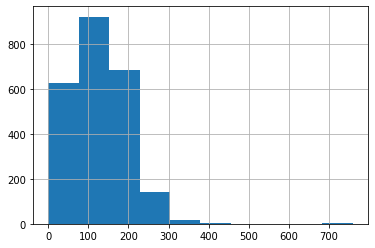

In [35]:
data = dfclean02['clean_sentence_EDA']
data.str.len().hist()

## Words Data Distribution

In [36]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [37]:
import nltk.data
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')


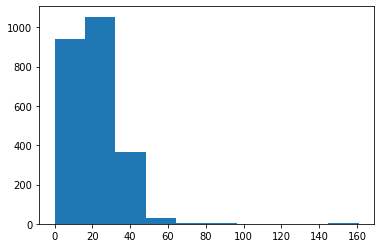

In [38]:
counts = []

for sentence in dfclean02['clean_sentence_EDA']:
    sentence = word_tokenize(str(sentence))
    word_count = len(sentence)
    counts.append(word_count)

plt.hist(counts)
plt.show()

## Basic Metrics

In [39]:
total_num_words = sum(counts) # total number of words
average_sentence_length = np.mean(counts) # print everage sentence length

word_lengths = []
for sentence in dfclean02['clean_sentence_EDA']:
    sentence = word_tokenize(str(sentence))
    for word in sentence:
        length = len(word)
        word_lengths.append(length)

average_word_length = np.mean(word_lengths) # print everage word length

print(f'Total number of words in the dataset: {total_num_words} words.')
print(f'Average length of words in the dataset: {average_word_length} characters.')
print(f'Average length of sentences in the dataset: {average_sentence_length} words.')

Total number of words in the dataset: 52030 words.
Average length of words in the dataset: 4.943359600230636 characters.
Average length of sentences in the dataset: 21.679166666666667 words.


## Filter Data to Get Label 1

In [40]:
dfbias=dfclean02[dfclean02['label'] == 1] 
dfbias

,Corpus Name,raw_sentence,label,clean_sentence_training,clean_sentence_EDA
0,Elections,@SukiRavan @ProgressPotato @MarkZuckerb0rg @JS...,1,Suki Rav an Progress Potato Mark Zucker b rg J...,Suki Rav an Progress Potato Mark Zucker b rg J...
1,Elections,@Newsweek Are you freaking crazy????[NEWLINE]I...,1,Newsweek freak crazy NEWLINE Id rather watch R...,Newsweek freak crazy NEWLINE Id rather watch R...
2,Elections,Undecided voters (and MAGATs alike);[NEWLINE]I...,1,Undecided voters and MAG AT s a like NEWLINE I...,Undecided voters and MAG AT s a like NEWLINE I...
3,Elections,@cheaterwins @Hungry_For_More @DAYSORSHAY So a...,1,cheater win Hungry For More DAYS OR SHAY right...,cheater win Hungry For More DAYS OR SHAY right...
4,Elections,@CNN Nancy Pelosi and the Dems wont do a deal ...,1,CNN Nancy Pelosi Dem s wont deal would make Tr...,CNN Nancy Pelosi Dem s wont deal would make Tr...
...,...,...,...,...,...
2395,Elections,Just lost a ton of followers again. Looks like...,1,lose ton followers again Looks like Im part Tw...,lose ton followers again Looks like Im part Tw...
2396,Elections,@NovumQuid @OpenMothersMale @MikeSington I hav...,1,N ovum Quid Open Mothers Male Mike Sing ton De...,N ovum Quid Open Mothers Male Mike Sing ton De...
2397,Elections,@TheLeoTerrell @SenatorLoeffler @realDonaldTru...,1,The Leo Terrell Senator Loe ff ler real Donald...,The Leo Terrell Senator Loe ff ler real Donald...
2398,Elections,It’s too bad that at a time when we’re unemplo...,1,Its bad time be unemployed government wont hel...,Its bad time be unemployed government wont hel...


## Frequent Words

In [41]:
all_words = []

for sentence in dfbias['clean_sentence_EDA']:
    words = word_tokenize(str(sentence))
    for word in words:
        all_words.append(word)

print(all_words[:100])

['Suki', 'Rav', 'an', 'Progress', 'Potato', 'Mark', 'Zucker', 'b', 'rg', 'JS', 'if', 'ford', 'on', 'Kyle', 'Kulin', 'ski', 'Joe', 'Biden', 'better', 'vote', 'him', 'Newsweek', 'freak', 'crazy', 'NEWLINE', 'Id', 'rather', 'watch', 'Ro', 'to', 'Rooter', 'team', 'clean', 'sewers', 'Bronze', 'Boy', 'spew', 'endless', 'lie', 'distortions', 'Its', 'old', 'old', 'racist', 'crap', 'America', 'fall', 'deserve', 'get', 'NEWLINE', 'Vote', 'Blue', 'Undecided', 'voters', 'and', 'MAG', 'AT', 's', 'a', 'like', 'NEWLINE', 'If', 'worry', 'Joe', 'sniff', 'hair', 'worry', 'tRUmp', 'grab', 'someone', 's', 'pu', 'y', 'NEWLINE', 'NEWLINE', 'If', 'worry', 'Hunter', 'worry', 'Ivan', 'ka', 'NEWLINE', 'NEWLINE', 'If', 'worry', 'Kamala', 'worry', 'Mike', 'cheater', 'win', 'Hungry', 'For', 'More', 'DAYS', 'OR', 'SHAY', 'right', 'President', 'Trump', 'likely']


## Frequent Words and their Number

In [42]:
from collections import Counter

In [43]:
most_common = Counter(all_words).most_common(20)
print(most_common)

[('NEWLINE', 2252), ('Trump', 1567), ('Biden', 1490), ('Harris', 1010), ('Joe', 642), ('s', 496), ('Kamala', 487), ('Vote', 437), ('Donald', 359), ('vote', 321), ('real', 320), ('Blue', 234), ('America', 223), ('President', 221), ('get', 192), ('MAGA', 192), ('say', 178), ('go', 153), ('like', 149), ('trump', 144)]


## Most Frequent Words

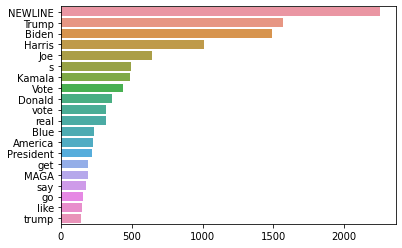

In [44]:
words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words)

## Clean Text for the second time

In [45]:
all_words_clean = []

for sentence in dfbias['clean_sentence_EDA']:
    words = word_tokenize(str(sentence))
    for word in words:
        word = word.lower() # lowercase all word
        if len(word) >= 3: # quick solution to get rif of contractions
            # find better solution in official version
            all_words_clean.append(word)

print(all_words_clean[:100])

['suki', 'rav', 'progress', 'potato', 'mark', 'zucker', 'ford', 'kyle', 'kulin', 'ski', 'joe', 'biden', 'better', 'vote', 'him', 'newsweek', 'freak', 'crazy', 'newline', 'rather', 'watch', 'rooter', 'team', 'clean', 'sewers', 'bronze', 'boy', 'spew', 'endless', 'lie', 'distortions', 'its', 'old', 'old', 'racist', 'crap', 'america', 'fall', 'deserve', 'get', 'newline', 'vote', 'blue', 'undecided', 'voters', 'and', 'mag', 'like', 'newline', 'worry', 'joe', 'sniff', 'hair', 'worry', 'trump', 'grab', 'someone', 'newline', 'newline', 'worry', 'hunter', 'worry', 'ivan', 'newline', 'newline', 'worry', 'kamala', 'worry', 'mike', 'cheater', 'win', 'hungry', 'for', 'more', 'days', 'shay', 'right', 'president', 'trump', 'likely', 'win', 'biden', 'base', 'likelihood', 'say', 'who', 'win', 'president', 'trump', 'likely', 'win', 'newline', 'newline', 'trump', 'keep', 'america', 'great', 'trump', 'the', 'best']


In [46]:
most_common2 = Counter(all_words_clean).most_common(20)
print(most_common2)

[('newline', 2252), ('trump', 1791), ('biden', 1572), ('harris', 1053), ('vote', 825), ('joe', 706), ('kamala', 526), ('donald', 370), ('real', 341), ('president', 319), ('blue', 266), ('america', 246), ('get', 221), ('maga', 206), ('the', 204), ('say', 188), ('people', 177), ('like', 159), ('make', 154), ('need', 137)]


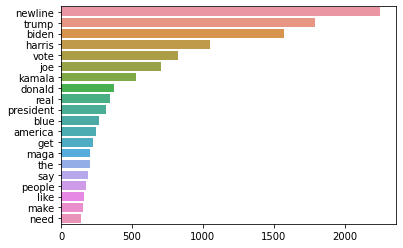

In [47]:
words, frequency = [], []
for word, count in most_common2:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words)

## Checking out data balance

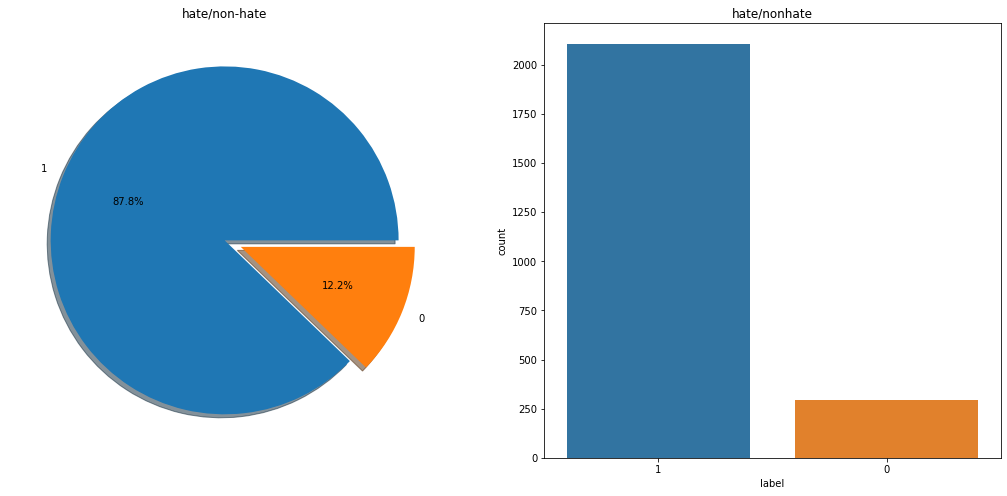

In [48]:
f,ax=plt.subplots(1,2,figsize=(18,8))
dfclean02['label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('hate/non-hate')
ax[0].set_ylabel('')
sns.countplot(x=dfclean02['label'],order = dfclean02['label'].value_counts().index,ax=ax[1])
ax[1].set_title('hate/nonhate')
plt.show()

** We can see that there is very imbalance data**

## Words Cloud

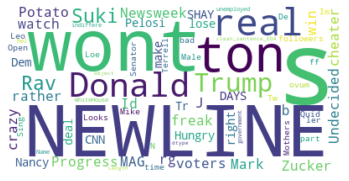

In [49]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(dfbias['clean_sentence_EDA']))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()